In [1]:
import sys
sys.path.append('../../ABEL/')
from abel import *

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import matplotlib.pyplot as plt
from abel.utilities.relativity import energy2gamma
import scipy.special as sc

In [67]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
driver.seed = 1 #5
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 11 # [m]
stage.nom_energy_gain = 31.9e9 # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = True
stage.save_evolution = False
if stage.enable_radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5000e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.0
source.bunch_length = 10e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.1e-9 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
source.seed = driver.seed
#beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

In [68]:
stage.enable_radiation_reaction = False
# define linac
linac1 = Linac()
linac1.source = source
linac1.stage = stage
linac1.num_stages = 1
shots1 = 1
linac1.run('energy_loss_noRR_5TeV', num_shots=shots1, overwrite=True, parallel=False)

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5000.0 GeV, -1.60 nC, 0.0% rms, 157.6/0.0 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 5032.3 GeV, -1.60 nC, 0.1% rms, 157.6/0.0 µm-rad)


In [69]:
stage.enable_radiation_reaction = True
# define linac
linac3 = Linac()
linac3.source = source
linac3.stage = stage
linac3.num_stages = 1
shots3 = 1
linac3.run('energy_loss_RR_5TeV', num_shots=shots3, overwrite=True, parallel=False)

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5000.0 GeV, -1.60 nC, 0.0% rms, 157.6/0.0 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 5021.6 GeV, -1.60 nC, 0.2% rms, 157.1/0.0 µm-rad)


In [70]:
E1 = linac1.get_beam(-1).energy()/1e9
E3 = linac3.get_beam(-1).energy()/1e9
E_nom = E1-source.energy/1e9
print((E1-E3))
print(E1-source.energy/1e9)

10.739532692331522
32.347576544008916


In [4]:
# define linac
linac2 = Linac()
linac2.source = source
linac2.stage = stage
linac2.num_stages = 1
shots = 1
num_jitter_values = 3
jitter_values = np.linspace(1e-7,1e-6,num_jitter_values)
print(jitter_values)
# scan the driver timing jitter
linac2.scan(f'scan_jitter_with_RR_{stage.enable_radiation_reaction}', 
           lambda obj, val: setattr(obj.stage.driver_source.jitter, 'x', val) or obj, 
           jitter_values,
           label='Driver jitter [$\mu m$]',
           scale=1e-6,
           num_shots_per_step=350, 
           parallel=True,
           overwrite=True,
           max_cores = 8);

Output()

Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1


/home/daniel/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A 
worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a
memory leak.
  warnings.warn(

Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of cores: 1
Number of co

In [5]:
#linac.plot_beam_function(Beam.rel_energy_spread, label='Rel energy spread (%)', scale=1e-2, xscale='log')
#linac.plot_beam_function(Beam.norm_emittance_x, label='norm emittance x (mm mrad)', scale=1e-6, xscale='log')
#linac.plot_beam_function(Beam.norm_emittance_y, label='norm emittance y (mm mrad)', scale=1e-6, xscale='log')
#linac.plot_beam_function(lambda obj:obj.energy() - source.energy, label='Energy Gain (GeV)', scale=1e9, xscale='log')

In [6]:
list_of_E_arrays = [ [] for _ in range(num_jitter_values)]
print(list_of_E_arrays)
for j in range(num_jitter_values):
    Es = [linac2[j,i].get_beam(-1).energy()/1e9 for i in range(linac.num_shots_per_step)]
    list_of_E_arrays[j] = Es

[[], [], []]


In [71]:
def rho(sig_jitter, El):
    #El = GeV
    gamma = energy2gamma(source.energy+11e9)
    kp = pp.k_p(stage.plasma_density)
    k_beta = kp/np.sqrt(2*gamma)
    sig_x_sq = source.emit_nx/k_beta/gamma
    sig_y_sq = source.emit_ny/k_beta/gamma
    
    delta_x = 2*(El*SI.e*1e9*12*np.pi*SI.epsilon_0/SI.e**2/stage.length/(gamma*k_beta)**4 - 2*sig_x_sq)

    energy_loss_dist = 2/sig_jitter/np.sqrt(2*np.pi)*12*np.pi*SI.epsilon_0/SI.e**2/stage.length/(gamma*k_beta)**4/np.sqrt(delta_x)*SI.e*1e9\
    * np.exp(-1/2*delta_x/sig_jitter**2)
    

    return energy_loss_dist

5032.227576544009
nan
nan
nan


<Figure size 640x480 with 0 Axes>

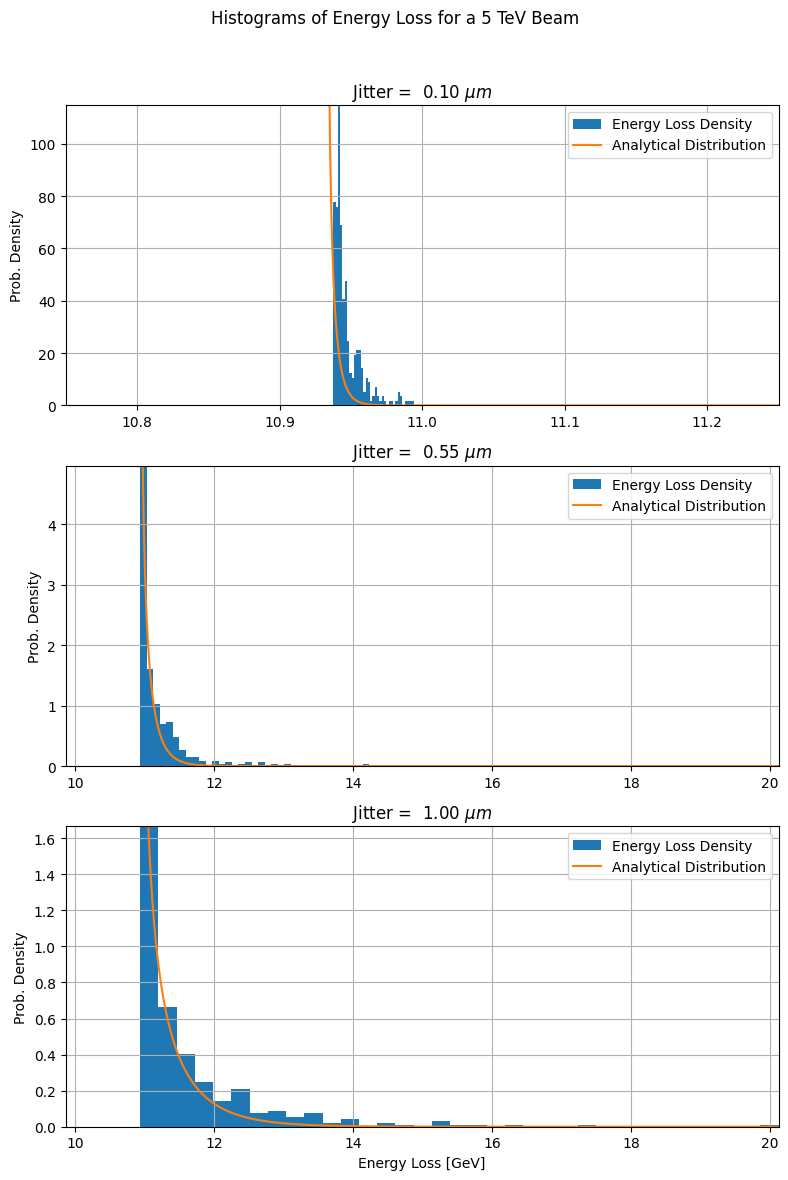

In [81]:
plt.subplots_adjust(hspace=0.4)
fig, axs = plt.subplots(num_jitter_values,1, figsize = (8,12))
fig.suptitle('Histograms of Energy Loss for a 5 TeV Beam')

if num_jitter_values<2:
    axs = [axs]

gamma = energy2gamma(source.energy+20e9)
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x_sq = source.emit_nx/k_beta/gamma
sig_y_sq = source.emit_ny/k_beta/gamma
E_nom_final = (E1-0.12)
print(E_nom_final)

energy_loss_beam = SI.e**2*stage.length/6/np.pi/SI.epsilon_0*(gamma*k_beta)**4*(sig_x_sq+sig_y_sq)/SI.e/1e9

for j, ax in enumerate(axs):
    bins = 35
    hist = np.histogram(E_nom_final - np.array(list_of_E_arrays[j]), bins = bins, density = True)
    ax.hist(E_nom_final - np.array(list_of_E_arrays[j]), bins = bins, density = True, stacked = True, label= 'Energy Loss Density')
    if j ==0:
        xlim = [10.75,11.25]
        Els = np.linspace(xlim[0],xlim[-1], 100000)
        ax.set_xlim(xlim)
        ax.set_ylim(0,max(hist[0]))
        ax.plot(Els, rho(jitter_values[j],Els), label= 'Analytical Distribution')
    if j>0:
        xlim = [energy_loss_beam-1e-1*energy_loss_beam, max(E_nom_final - np.array(list_of_E_arrays[-1]))]
        Els = np.linspace(xlim[0],xlim[-1], 100000)
        ax.plot(Els, rho(jitter_values[j],Els), label= 'Analytical Distribution')
        ax.set_xlim(xlim)
        ax.set_ylim(0,max(hist[0]))
    print(max(rho(jitter_values[j],Els)))
    ax.set_title(f'Jitter = {jitter_values[j]*1e6: .2f} $\mu m$')
    ax.set_ylabel('Prob. Density')
    ax.grid()
    ax.legend()
axs[-1].set_xlabel('Energy Loss [GeV]')
plt.tight_layout()
plt.subplots_adjust(top=0.90)

In [61]:
#fig.savefig(f'Plots/Jitter/final_energy_histograms_\
#{num_jitter_values}_jitter_values', bbox_inches = 'tight')